<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Для начала импортируем необходимые функции и библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

Далее, загрузим исходные данные и ознакомимся с ними.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
def data_info(data):
    print(data.info())
    print(data.isna().sum() / data.shape[0])
    print(data.head(5))

In [4]:
data_info(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
num_orders    0.0
dtype: float64
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


Пропусков в данных нет, типы данных адекватны. Можно переходить к дальнейшей подготовке.

Отсортируем данные по времени (индексу).

In [5]:
df = df.sort_index()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Укрупним данных, в соответствие с условиями задачи до промежутков в 1 час.

In [6]:
df = df.resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Данные готовы к дальнейшей работе.

## Анализ

Для начала посомтрим на тренд, сезонность и шум в данных.

<AxesSubplot:title={'center':'Trend'}, xlabel='datetime'>

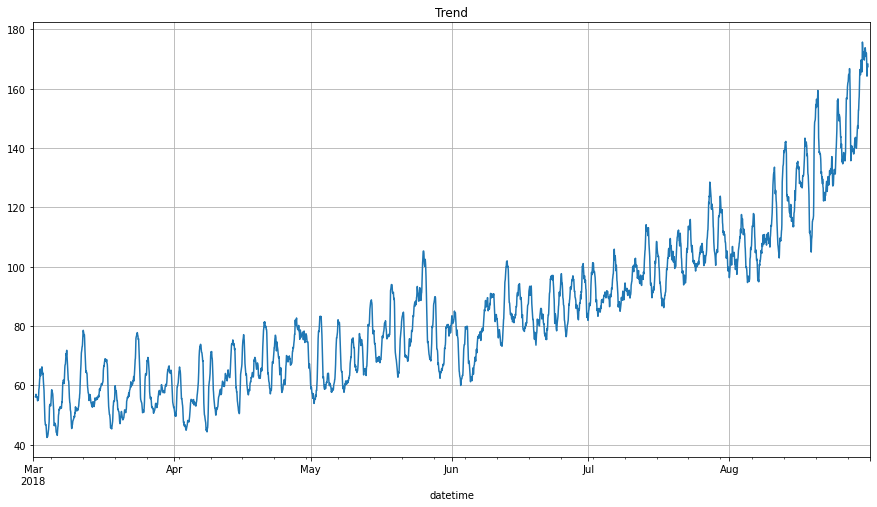

In [7]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot(figsize=(15,8), grid=True, title='Trend')

Заметен явный восходящий тренд.

<AxesSubplot:title={'center':'Seasonal'}, xlabel='datetime'>

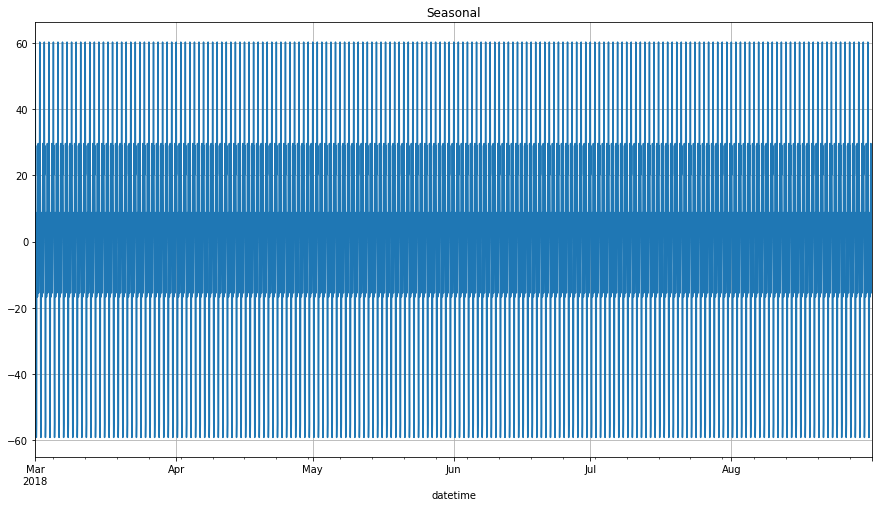

In [8]:
decomposed.seasonal.plot(figsize=(15,8), grid=True, title='Seasonal')

В данном масшатбе тяжело что-то говорить о сезонности кроме того, что она есть. Далее подробнее исследуем этот вопрос.

<AxesSubplot:title={'center':'Resid'}, xlabel='datetime'>

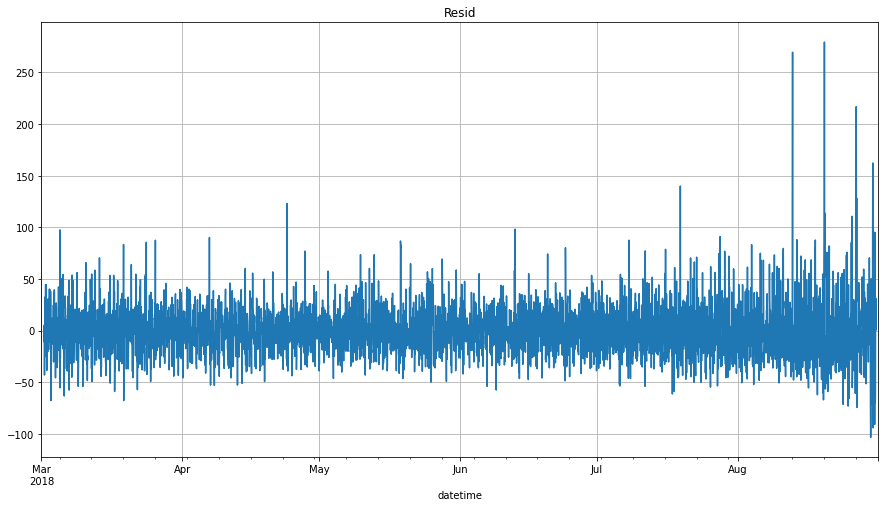

In [9]:
decomposed.resid.plot(figsize=(15,8), grid=True, title='Resid')

В данных имеется сильный шум. Это осложнит предсказание.

Попробуем убрать часть шумов, перейдя от абсолютного значения с среднему значению за 24 часа. Так же ознакомимся со стандартным отклонением за этот же период.

<AxesSubplot:title={'center':'Mean and std for 1 day'}, xlabel='datetime'>

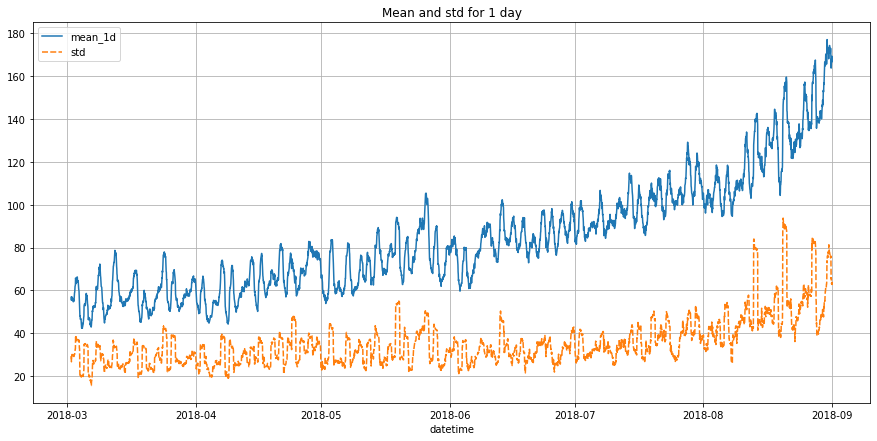

In [10]:
df1 = df.copy(deep=True)
df1['mean_1d'] = df['num_orders'].rolling(24).mean()
df1['std'] = df['num_orders'].rolling(24).std()
df1 = df1.dropna()
fig, ax1 = plt.subplots(figsize=(15,7))
plt.grid()
plt.title('Mean and std for 1 day')
sns.lineplot(data=df1[['mean_1d', 'std']], ax=ax1)

В данных все так же есть шумы. Отдано уже можем говорить о том, что ряд не стаионарный. И среднее значение и стандартное отклонение меняются.

Ещё сгладим данные, взяв период в 1 неделю.

<AxesSubplot:title={'center':'Mean and std for 7 day'}, xlabel='datetime'>

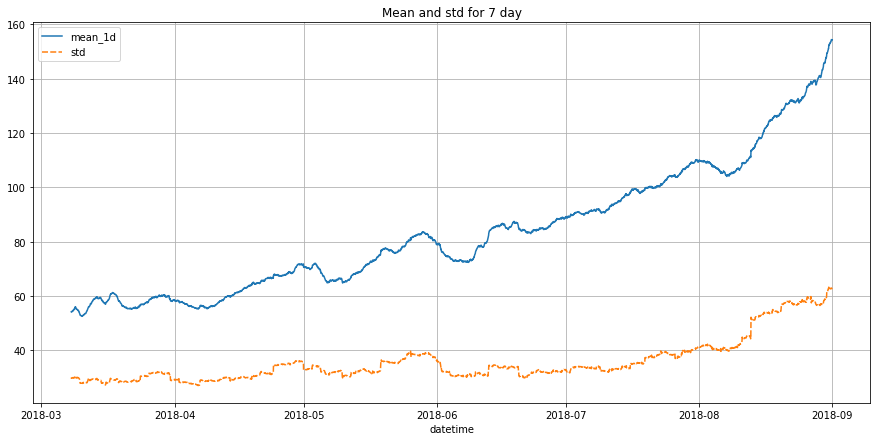

In [11]:
df1 = df.copy(deep=True)
df1['mean_1d'] = df['num_orders'].rolling(24*7).mean()
df1['std'] = df['num_orders'].rolling(24*7).std()
df1 = df1.dropna()
fig, ax1 = plt.subplots(figsize=(15,7))
plt.grid()
plt.title('Mean and std for 7 day')
sns.lineplot(data=df1[['mean_1d', 'std']], ax=ax1)

Теперь можно однозначно говорить, что среднее значение числа заказов и их стандартное отклонение во времени растут.

Проверим сезонность данных. Выберем для этого строки соответствующие времени *00:00:00* для каждого дня в выборке.
Если сезонность имеется, то разность фактического количества заказов и смещенного на 7 дней будут примерно равны, в то время, как такая же разность, но для смещение в 1 день, будут значительно отличасться.

Построим графики и проверим это.

<AxesSubplot:title={'center':'Value with an offset of 7 day'}, xlabel='datetime'>

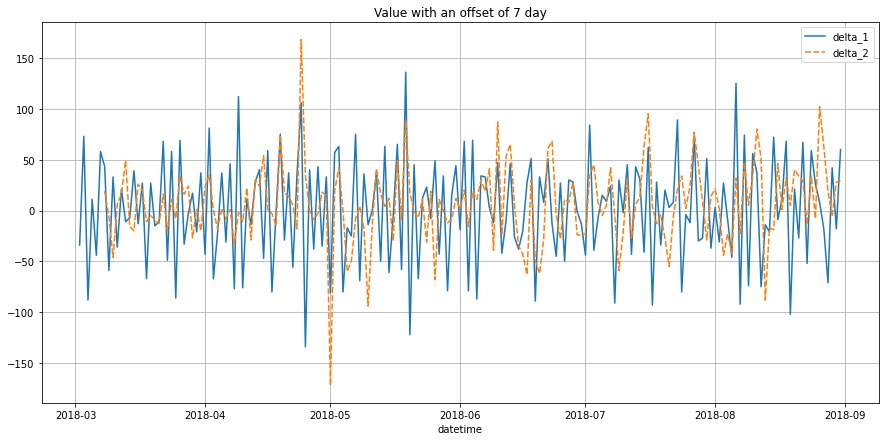

In [12]:
del df1
df1 = df.copy(deep=True)
time_s = pd.Timestamp('00:00:00').time()
df1 = df1[df1.index.time == time_s]
df1['delta_1'] = df1['num_orders'] - df1['num_orders'].shift(1)
df1['delta_2'] = df1['num_orders'] - df1['num_orders'].shift(7)
fig , ax1 = plt.subplots(figsize=(15,7))
plt.grid()
plt.title('Value with an offset of 7 day')
sns.lineplot(data=df1[['delta_1', 'delta_2']], ax=ax1)

Из графиков видно, что сезонность имеется и её период равен примерно 7 дням. Посмотрим на числовое выражение этого заключения.
Выведем стандартное отклоние для исходной выборки. MAE дельты заказов со смещением в 1 час (из исходной выборки) и MAE дельты для смещений в 1 и 7 дней у преобразованной выборки.

In [13]:
print('all_str', df['num_orders'].std())
print('delta_1H', (df['num_orders']-df['num_orders'].shift(1)).abs().mean())
print('delta_1D', df1['delta_1'].abs().mean())
print('delta_7D', df1['delta_2'].abs().mean())

all_str 45.023853419354026
delta_1H 29.19977349943375
delta_1D 43.387978142076506
delta_7D 27.779661016949152


MAE для смещения в 7 дней оказалось меньше, как и было предположенно исходя из графиков. При этом MAE меньше стандартного отклонения по исходной выборке.

### Выводы

Было определено, что у нас представлен не стационарный временной ряд.
У значений из выборки четко прослеживается восходящий тренд, а так же сезонность с периодом 7 дней. В значениях имеется сильный шум, который затрудним предсказание.

## Обучение

Обучать будем 5 моделей: решающее дерево, рандомный лес, линейную регрессию и CatBoost. Адекватность модели проверим на модели dummy.

Создадим несколько функций. Первые две будум делить выборку на две части, не перемешивая строки и создавать новые признаки для обучения. Исходя из анализа будем использовать смещение кратное 7 дням.

In [14]:
def train_split(df):
    # деление выборок на тестовую и тренировочную
    train, test = train_test_split(df, test_size=0.1, random_state=123, shuffle=False)
    return train, test

def make_features(df, rol, log, st):
    # создание новых признаков
    
    df['sm'] = df['num_orders'].shift(1).rolling(rol).mean()
    df['st'] = df['num_orders'].shift(1).rolling(st).std()
    # срднее значение и стандартное отклонине за rol и st часов

    #df['month'] = df.index.month
    #df['day'] = df.index.day
    
    df['dayWeek'] = df.index.dayofweek
    df['house'] = df.index.hour
    # разбитие даны и времени на отдельные показатели
    
    for i in range(1, log):
        st = 'log_' + str(i)
        df[st] = df['num_orders'].shift(24*7 * i)
    df = df.dropna()
    # создание смещенных данных на период кратный 7 дням
    
    return train_split(df)

Следубщие две функции будут обучать модель и производить кросс-валидацию и учетом требования: не перемешивать строки (не использовать данные из будщего).

In [15]:
def fit_m(model, t_f, t_t, v_f, v_t):
    # обучение модели, возвращает RMSE
    model.fit(t_f, t_t)
    model.predict(v_f)
    return mean_squared_error(model.predict(v_f), v_t) ** 0.5

def timeSeachCV(train, x, model):
    # кросс-валидация
    
    per = train.shape[0] // x
    # разбитие на отрезки
    list_score = list()
    
    for i in range(1,x):
        stop = per * i
        tr = train[:stop]
        vl = train[stop:]
        list_score.append(fit_m(
            model, tr.drop('num_orders', axis=1), tr['num_orders'], vl.drop('num_orders', axis=1), vl['num_orders']))
        scor = sum(list_score) / len(list_score)
    # последовательное прохождение отрезков с обученим
    
    return scor

А так же функции обучение каждой модели, каждая функция возвращает лучшую оценку и значение гиперпараметров, при которых оценка была получена.

In [16]:
def tree_m(df):
    best_score = 10000
    best_params = 0
    for i in range(3,10):
        model = DecisionTreeRegressor(max_depth=i)
        result = timeSeachCV(train, 3, model)  
        if result < best_score:
            best_score = result
            best_params = i
    return [best_score, best_params]

In [17]:
def forest_m(df):
    best_score = 10000
    best_params = 0
    for est in range(90, 121, 10):
        for depth in range(5,10):
            model = RandomForestRegressor(max_depth=depth, n_estimators=est)
            result = timeSeachCV(train, 3, model)  
        if result < best_score:
            best_score = result
            best_params = (depth, est)
    return [best_score, best_params]

In [18]:
def lin_m(df):
    model = LinearRegression()
    return [timeSeachCV(train, 3, model), ()]

In [19]:
def cat_m(df):
    model = CatBoostRegressor(loss_function='RMSE', verbose=False)
    return [timeSeachCV(train, 3, model), ()]

In [20]:
def dummy_m(df):
    st = ['mean', 'median']
    best_score = 10000
    best_params = ''
    for s in st:
        model = DummyRegressor(strategy=s)
        result = timeSeachCV(train, 3, model)  
        if result < best_score:
            best_score = result
            best_params = s
    return [best_score, best_params]

Итерационно обучим каждую модель, определяя наилучшие гиперпараметры и значения смещения данных.

In [21]:
list_result = list()
list_columns = ['log', 'tree', 'forest', 'lin', 'cat','dummy', 'param_tree', 'param_forest', 'param_dummy']

for log in range(1, 4):
    # log - множитель коэффициента (он равен 24) смещения данных
    
    print('log', log)
    df1 = df.copy(deep=True)
    train, test = make_features(df1, 24, log, 24)
    res1 = tree_m(train)
    res2 = forest_m(train)
    res3 = lin_m(train)
    res4 = cat_m(train)
    res5 = dummy_m(train)
    del df1
    list_result.append([log, res1[0], res2[0], res3[0], res4[0], res5[0],res1[1], res2[1], res5[1]])

all_res = pd.DataFrame(data=list_result, columns=list_columns)

log 1
log 2
log 3


Ознакомимся с результатами.

In [22]:
all_res

,log,tree,forest,lin,cat,dummy,param_tree,param_forest,param_dummy
0,1,38.015870,33.772180,39.470911,35.089720,49.703856,7,"(9, 110)",mean
1,2,29.319171,26.846228,27.359996,27.726334,49.541828,5,"(9, 90)",mean
2,3,28.773194,26.563283,25.389838,27.492423,49.711117,5,"(9, 120)",mean


Лучшие результаты получены для линейной регрессии, при множителе коэффицента смещения значений 3.

### Выводы

Мы рассмотрели разные модели. Все они оказались адекватными. Наилучший результат показала модель линейной регрессии.
Так же стоит обратить внимание, что при увеличение числа и периодов смешений (7, (7,14), (7,14,21)) улушается качество модели на тестовой выборке. Это модет быть рабочим способом ещё улучшить качество предсказаний.


## Тестирование

Проверим выбранную модель на тестовой выборке.

In [23]:
model = LinearRegression()
df2 = df.copy(deep=True)
train, test = make_features(df2, 24, 3, 24)
model.fit(train.drop('num_orders', axis=1), train['num_orders'])
predict = model.predict(test.drop('num_orders', axis=1))
print(mean_squared_error(predict, test['num_orders']) ** 0.5)

34.73068583858713


Модель показала результаты несколько хуже, чем при обучении, но при этом все ещё адекватна и удовлетворяет условиям задачи.

Отдельно ознакомимся с результатами предсказаний. Создадим датасет и графически исзобразим ошибки.

In [24]:
ddd = pd.DataFrame(test['num_orders'])
ddd['pred'] = predict
ddd.head(10)

,num_orders,pred
datetime,,
2018-08-15 00:00:00,211,203.612700
2018-08-15 01:00:00,98,137.294113
2018-08-15 02:00:00,157,149.989990
2018-08-15 03:00:00,102,111.257859
2018-08-15 04:00:00,137,120.174780
2018-08-15 05:00:00,85,88.846395
2018-08-15 06:00:00,36,86.788394
2018-08-15 07:00:00,28,54.307944
2018-08-15 08:00:00,92,103.180190


In [25]:
ddd = ddd['2018-08-15 00:00:00': '2018-08-17 00:00:00']
ddd.head(10)

,num_orders,pred
datetime,,
2018-08-15 00:00:00,211,203.612700
2018-08-15 01:00:00,98,137.294113
2018-08-15 02:00:00,157,149.989990
2018-08-15 03:00:00,102,111.257859
2018-08-15 04:00:00,137,120.174780
2018-08-15 05:00:00,85,88.846395
2018-08-15 06:00:00,36,86.788394
2018-08-15 07:00:00,28,54.307944
2018-08-15 08:00:00,92,103.180190


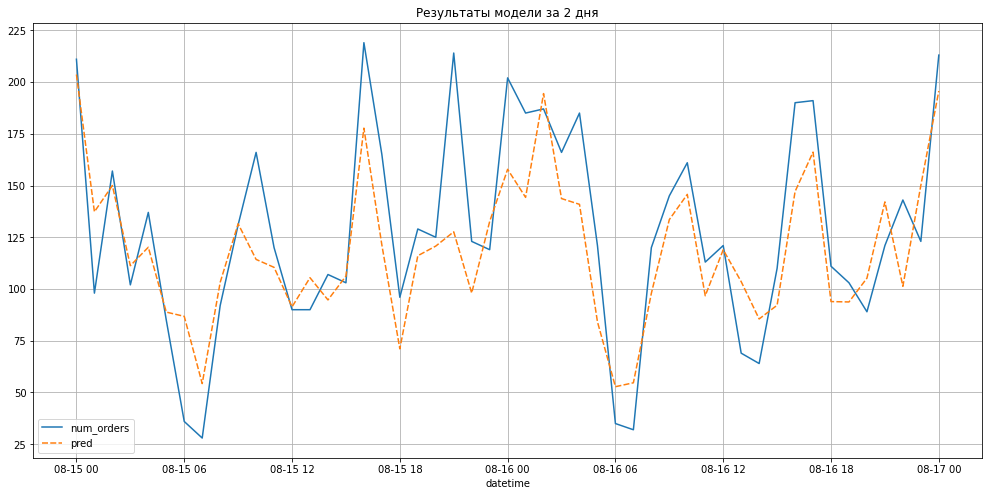

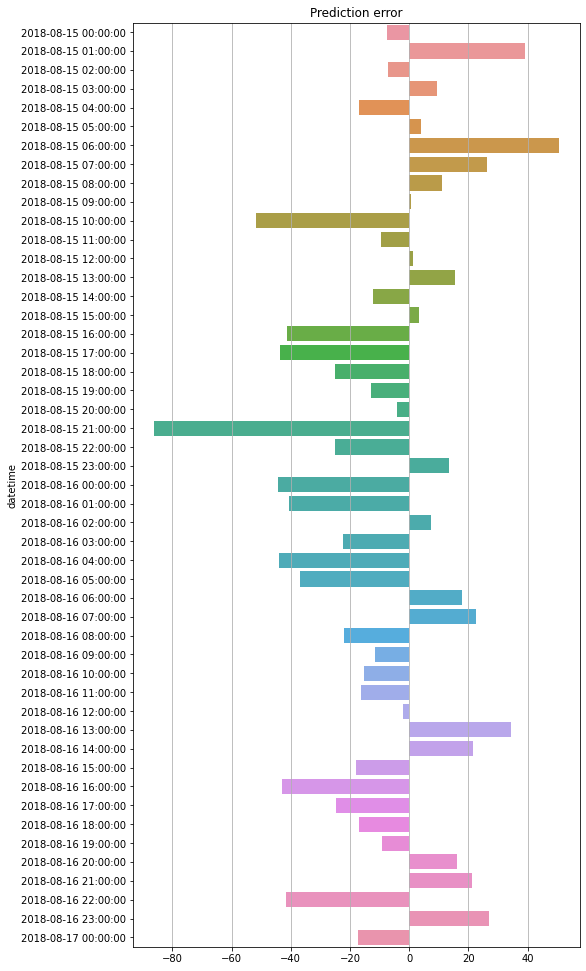

In [26]:
fig, ax1 = plt.subplots(figsize=(17, 8))
plt.grid()
plt.title('Результаты модели за 2 дня')
sns.lineplot(data=ddd, ax=ax1)
plt.show()
fig, ax2 = plt.subplots(figsize=(8, 17))
plt.grid()
plt.title('Prediction error')
sns.barplot(data=ddd, y=ddd.index, x=ddd['pred'] - ddd['num_orders'], ax=ax2)
plt.show()

Из графика видно, что модель хорошо предсказывает момент появления скачков, но плохо предсказывает их величину. Это может стать направлением для улучшения модели.

## Общие выводы

В ходе работы мы загрузили, подготовили и проанализировали исходные данные.

Убедились, что временной ряд не стационарен, имеет выраженный восходящий тренд и сезонность с периодом в 7 дней.

Далее, были обучены разные модели и выбрана наилучшая. Так же были определены параметры для создания доп. признаков.

Выбраная модель была проверяна на тестовой выборке и показала удовлетворительный результатэ